In [1]:
import glob
import logging
import os
import time
from itertools import repeat
from multiprocessing.pool import Pool
from pathlib import Path

import cartopy.crs as ccrs
import geopandas
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray
from tqdm import tqdm

import G211
from lightning import get_obs, ztfs
%matplotlib inline
from ml_functions import get_argparser, get_features, get_flash_pred, load_df, predct2
from spc import get_issuance_time, get_outlooks
from statisticplot import make_map, stat_plots

sns.set_theme()

logging.basicConfig(level=logging.WARNING, format="%(asctime)s %(message)s", force=True)
tmpdir = Path(os.getenv("TMPDIR"))

2023-11-27 15:07:37.940399: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-27 15:07:38.082068: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# %load_ext autoreload
# %autoreload 2

In [3]:
# map projection
map_crs = G211.g211
grid = G211.grid
grid = grid.to_crs(ccrs.PlateCarree())

conus_mask = G211.mask

### Load SPC enhanced tstm outlook

In [4]:
# downloaded by get_enhtstm.ipynb
tmpdir = Path(os.getenv("TMPDIR"))
sfiles = (tmpdir / "enhtstm").glob("????/*.zip")
sfiles = sorted(sfiles)
column = "DN"

In [5]:
obsvar = "cg.ic"
o_thresh = 1
twin = 4
rptdist = 20
clobber = False

platform = "glm" if obsvar == "flashes" else "wbug"

f = f"{obsvar}_{rptdist}km_{twin}hr"

In [6]:
sfiles[0].name, sfiles[-1].name, len(sfiles)

('enh00_20200101_012000_202001010525-shp.zip',
 'enh20_20230630_301600_202306301252-shp.zip',
 15425)

In [7]:
teststart = "20201202"
testend = "20220101"
parser = get_argparser()
# use [0, 1, 2] time windows for ['sighail', 'sigwind', 'hailone', 'wind', 'torn']
# until we update parquet files with [1,2,4]
rpttwin = int(
    np.floor(twin / 2)
)  # Ryan's original way of naming storm rpt time windows
args = parser.parse_args(
    args="--seed -1 --model HRRR --batchsize 1024 --neurons 1024 --optim SGD"
    " --trainstart 20191002 --trainend 20201202 "
    f"--teststart {teststart} --testend {testend} "
    f"--flash {o_thresh} "
    f"--twin {twin} "
    f"--savedmodel /glade/work/ahijevyc/NSC_objects/nn/lightning/{o_thresh:02d}+.{twin}hr "
    "--labels "
    # f"sighail_{rptdist}km_{rpttwin}hr sigwind_{rptdist}km_{rpttwin}hr "
    # f"hailone_{rptdist}km_{rpttwin}hr wind_{rptdist}km_{rpttwin}hr torn_{rptdist}km_{rpttwin}hr any_{rptdist}km_{rpttwin}hr "
    f"cg_20km_{twin}hr ic_20km_{twin}hr cg.ic_20km_{twin}hr flashes_20km_{twin}hr "
    f"cg_40km_{twin}hr ic_40km_{twin}hr cg.ic_40km_{twin}hr flashes_40km_{twin}hr "
    " --epochs 10 --learning 0.001 --kfold 1".split()
)

args

Namespace(batchnorm=False, batchsize=1024, clobber=False, debug=False, dropout=0.0, epochs=10, labels=['cg_20km_4hr', 'ic_20km_4hr', 'cg.ic_20km_4hr', 'flashes_20km_4hr', 'cg_40km_4hr', 'ic_40km_4hr', 'cg.ic_40km_4hr', 'flashes_40km_4hr'], fhr=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48], fits=None, flash=1, folds=None, kfold=1, idate=None, ifile=None, learning_rate=0.001, model='HRRR', neurons=[1024], nfits=5, nprocs=0, optimizer='SGD', reg_penalty=0.01, savedmodel='nn/lightning/01+.4hr', seed=-1, trainend=Timestamp('2020-12-02 00:00:00'), trainstart=Timestamp('2019-10-02 00:00:00'), testend=Timestamp('2022-01-01 00:00:00'), teststart=Timestamp('2020-12-02 00:00:00'), twin=4, suite='default')

### Load big DNN DataFrame

In [8]:
def forecast_obs(sfile, twin, rptdist):
    """
    get forecast valid start and end from sfile string
    return (forecast, observations) tuple from same period
    """
    f = geopandas.read_file(sfile).to_crs(ccrs.PlateCarree())
    record = os.path.basename(sfile)

    issue, valid_start, valid_end = get_issuance_time(record)
    logging.info(f"{issue} {valid_start} {valid_end}")

    # Get observations from DataFrame df from ml_functions.load_df()
    # instead of lightning.get_obs()
    # so you have the same data, and don't "repeat" the same
    # function with different code.
    # get_obs allows GLM or WxBug to be missing for a time
    # but load_df does not.

    valid_times = pd.date_range(
        start=valid_start + pd.Timedelta(hours=twin / 2),
        end=valid_end - pd.Timedelta(hours=twin / 2),
        freq=f"{twin}H",
    )
    # if all valid_times are available
    if all(
        [
            valid_time in df.index.get_level_values("valid_time")
            for valid_time in valid_times
        ]
    ):
        # reduce initialization_time dimension for multiple
        # initialization_times that have the same valid_time.
        # obs is the same for each init time so just
        # take the mean.
        o = (
            df.loc[
                (slice(None), valid_times, slice(None), slice(None), slice(None)),
                args.labels,
            ]
            .groupby(["x", "y", "valid_time"])
            .mean()
        )
        o = o.groupby(["x", "y"]).sum()  # sum valid times
    else:
        return None

    # Assign value to grid points within polygons
    f = grid.sjoin(f, how="inner", rsuffix="poly")

    # geometry not needed; clutters merge with grid with 2 geometry columns
    f = f.drop(columns="geometry")
    f = f.merge(grid[conus_mask.values.ravel()], on=["x", "y"], how="right")
    # Assign 0 to points outside forecast polygons
    f.loc[f.DN.isna(), "DN"] = 0
    f["DN"] = f["DN"].astype(
        int
    )  # avoid object dtype (don't know why zero assignment above causes that)
    f["record"] = record
    f["issue"] = issue
    # convert to str avoids TypeError: Object of type Timestamp is not JSON serializable
    f["valid_start"] = valid_start.strftime("%Y%m%d %H:%M")
    f["valid_end"] = valid_end.strftime("%Y%m%d %H:%M")

    fo = f.merge(o, left_index=True, right_index=True)

    return fo

In [9]:
ffile = tmpdir / f"spc_fcst.{twin}hr.par"

if not clobber and os.path.exists(ffile):  # and os.path.exists(ofile):
    logging.warning(f"read {ffile} {os.path.getsize(ffile)/1e6:.1f}M ")
    spc_fcst = pd.read_parquet(ffile)
else:
    logging.warning(f"make new files {ffile}")
    # Use multiple cpus (like 36) and 30+GB memory. 4 cpus took 6+ hours.
    with Pool(processes=35) as pool:
        result = pool.starmap(
            forecast_obs,
            tqdm(zip(sfiles, repeat(twin), repeat(rptdist)), total=len(sfiles)),
        )

    spc_fcst = [x for x in result if x is not None]

    spc_fcst = pd.concat(spc_fcst).set_index("record", append=True)
    spc_fcst.drop(columns="geometry").to_parquet(ffile)

# tried saving this to parquet ofile but tuple in column broke arrow engine
spc_fcst["prodid"] = list(
    zip(
        spc_fcst.issue,
        pd.to_datetime(spc_fcst.valid_start).dt.hour,
        pd.to_datetime(spc_fcst.valid_end).dt.hour,
    )
)

2023-11-27 15:08:00,483 read /glade/derecho/scratch/ahijevyc/tmp/spc_fcst.4hr.par 4.6M 


## Define observation numpy array, geodataframe, thresholds

In [10]:
logging.info("trim spc_fcst to testing range of neural network")
before_trim = len(spc_fcst)
spc_fcst = spc_fcst[
    (pd.to_datetime(spc_fcst.valid_start) >= pd.to_datetime(teststart))
    & (pd.to_datetime(spc_fcst.valid_end) <= pd.to_datetime(testend))
]
logging.warning(
    f"kept {len(spc_fcst)}/{before_trim} ({len(spc_fcst)/before_trim:%}) spc fcsts"
)

2023-11-27 15:08:09,760 kept 6092664/6092664 (100.000000%) spc fcsts


In [11]:
assert "enh00_20211231_312000_202112310559-shp.zip" in spc_fcst.index.get_level_values(
    "record"
)

### Verify SPC enhanced tstm forecast

In [12]:
thresh = pd.Series([o_thresh], name=f"{obsvar} threshold")
pthresh = pd.Series([10, 40, 70], name=f"fcst prob\nthresh") / 100.0

In [13]:
def valid_hour_str(prodids):
    valid_hour_range = prodids[0][1:]  # last 2 elements of first prodids tuple
    same_valid_hour_range = len(set([x[1:] for x in prodids])) == 1
    if same_valid_hour_range:
        return " " + str(valid_hour_range)
    return ""

In [14]:
spc_fcst.head()

,,,index_poly,DN,issue,valid_start,valid_end,cg_20km_4hr,ic_20km_4hr,cg.ic_20km_4hr,flashes_20km_4hr,cg_40km_4hr,ic_40km_4hr,cg.ic_40km_4hr,flashes_40km_4hr,prodid
x,y,record,,,,,,,,,,,,,,
48,12,enh00_20201202_022000_202012020531-shp.zip,NaN,0,0600,20201202 20:00,20201203 00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(0600, 20, 0)"
49,12,enh00_20201202_022000_202012020531-shp.zip,NaN,0,0600,20201202 20:00,20201203 00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(0600, 20, 0)"
69,12,enh00_20201202_022000_202012020531-shp.zip,NaN,0,0600,20201202 20:00,20201203 00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(0600, 20, 0)"
70,12,enh00_20201202_022000_202012020531-shp.zip,NaN,0,0600,20201202 20:00,20201203 00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(0600, 20, 0)"
47,13,enh00_20201202_022000_202012020531-shp.zip,NaN,0,0600,20201202 20:00,20201203 00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(0600, 20, 0)"


In [15]:
(spc_fcst[args.labels] >= 1).mean()

cg_20km_4hr         0.033318
ic_20km_4hr         0.039962
cg.ic_20km_4hr      0.041743
flashes_20km_4hr    0.042392
cg_40km_4hr         0.056080
ic_40km_4hr         0.064564
cg.ic_40km_4hr      0.066771
flashes_40km_4hr    0.068232
dtype: float64

In [16]:
spc_fcst.shape

(6092664, 14)

380.0
[('1300', 0, 4)] [380] 0.1947
389.0
[('1700', 0, 4)] [389] 0.2254
398.0
[('2100', 0, 4)] [398] 0.2463
375.0
[('1700', 4, 12)] [375] 0.1657
400.0
[('2100', 4, 12)] [400] 0.1955
383.0
[('0130', 4, 12)] [383] 0.2576
386.0
[('0600', 12, 16)] [386] 0.1095
360.0
[('0600', 16, 20)] [360] 0.1349
415.0
[('1300', 16, 20)] [415] 0.1700
366.0
[('0600', 20, 0)] [366] 0.2794
406.0
[('1300', 20, 0)] [406] 0.2916
400.0
[('1700', 20, 0)] [400] 0.3110


2023-11-27 15:09:59,154 /glade/derecho/scratch/ahijevyc/tmp/enhtstm.01+cg.ic_20km.png


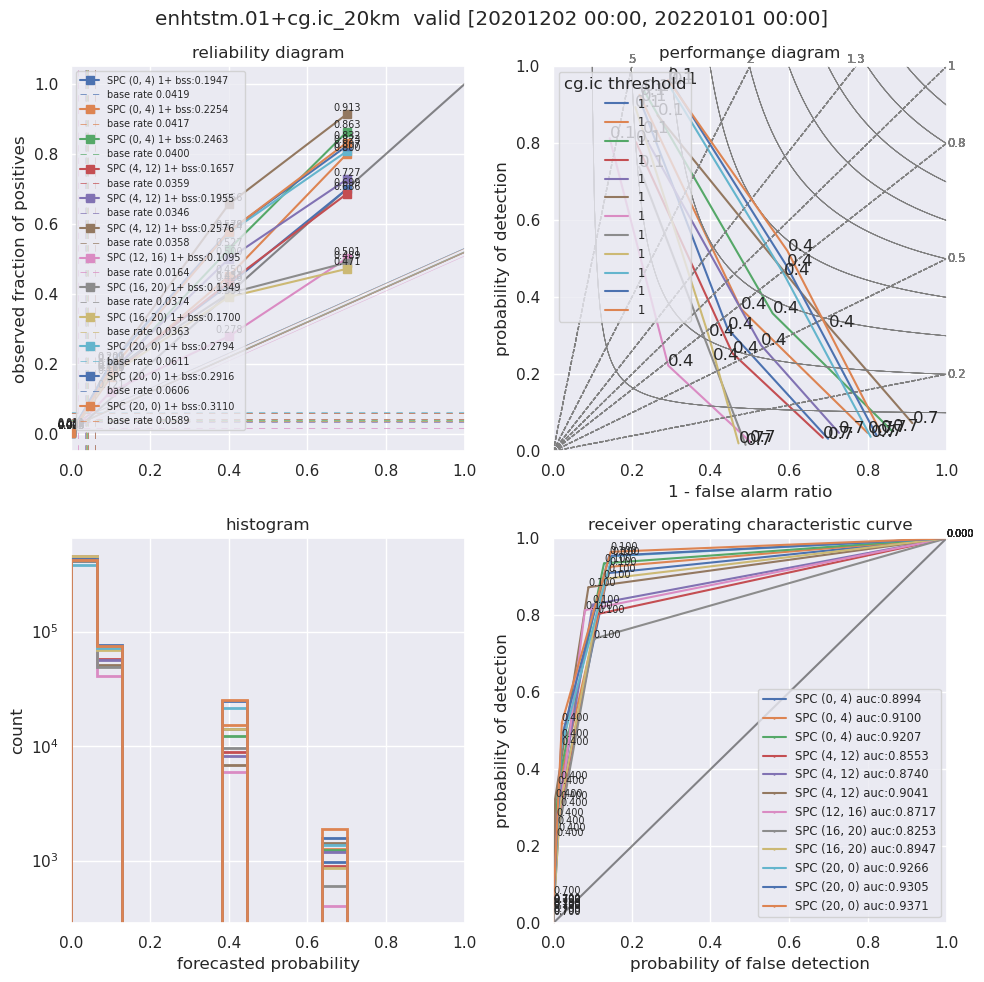

In [17]:
obs = spc_fcst[f]

fcst = spc_fcst
fcst = fcst.DN / 100

prodidss = [
    [("0600", 12, 16)],
    [("0600", 16, 20)],
    [("0600", 20, 0)],
]

# Aggregate by valid time
prodidss = [
    [("1300", 0, 4), ("1700", 0, 4), ("2100", 0, 4)],
    [("1700", 4, 12), ("2100", 4, 12), ("0130", 4, 12)],
    [("0600", 12, 16)],
    [("0600", 16, 20), ("1300", 16, 20)],
    [("0600", 20, 0), ("1300", 20, 0), ("1700", 20, 0)],
]

# Flatten list of lists to get every issuance and valid time in its own list
prodidss = [[x] for prodid in prodidss for x in prodid]
# All together
# prodidss = [[x for prodid in prodidss for x in prodid]]

ncols, nrows = 2, 2
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 5, nrows * 5))
title = ""
for prodids in prodidss:
    logging.info(f"forecast products for {len(prodids)} prodids")
    ihr = spc_fcst.prodid.isin(prodids)
    assert ihr.sum()
    print(ihr.sum() / 1308)

    # 1308 CONUS points per forecast
    cnt = (spc_fcst[ihr].groupby("prodid").size() / 1308).astype(int)

    print(cnt.index.values, cnt.values, end=" ")
    title += "  ".join([f"{c}{v}" for c, v in list(zip(cnt, cnt.index))])

    thisf = fcst[ihr]
    thisf.name = "SPC" + valid_hour_str(prodids)

    fig = stat_plots(
        obs[ihr],
        thisf,
        thresh=thresh,
        pthresh=pthresh,
        o_thresh=o_thresh,
        sep=0.01,
        n_bins=11,
        fig=fig,
    )

title = f"enhtstm.{o_thresh:02d}+{obsvar}_{rptdist}km"
title += f"  valid [{spc_fcst.valid_start.min()}, {spc_fcst.valid_end.max()}]"
plt.suptitle(title, wrap=True)
plt.tight_layout()
ofile = tmpdir / f"enhtstm.{o_thresh:02d}+{obsvar}_{rptdist}km.png"
plt.savefig(ofile)
logging.warning(ofile)

/glade/derecho/scratch/ahijevyc/tmp/cnt.png


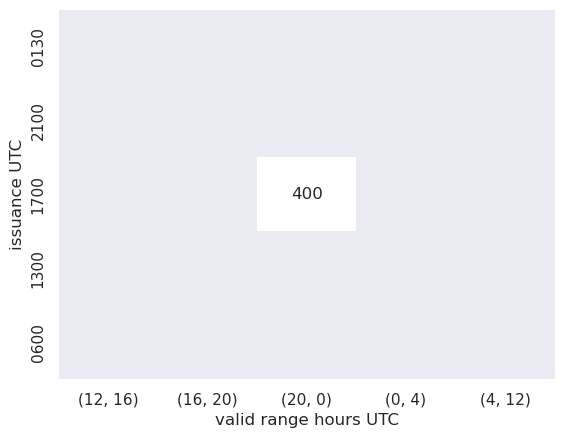

In [18]:
def plot_cnt(cnt, cmap=None):
    df = pd.DataFrame(
        cnt.index.tolist(),
        columns=["issuance UTC", "valid_start_hour", "valid_end_hour"],
    )
    df["valid range hours UTC"] = list(zip(df.valid_start_hour, df.valid_end_hour))
    df["n"] = cnt.values
    df = df.reset_index().pivot(
        columns="valid range hours UTC", index="issuance UTC", values="n"
    )
    df = df.reindex(
        ["0130", "2100", "1700", "1300", "0600"],
        columns=[(12, 16), (16, 20), (20, 0), (0, 4), (4, 12)],
    )
    g = sns.heatmap(df, annot=True, fmt="3.0f", cmap=cmap, cbar=False)
    return g


g = plot_cnt(
    cnt,
    cmap=mpl.colors.LinearSegmentedColormap.from_list(
        "cnt", ["white", fig.get_axes()[0].get_lines()[-1].get_color()]
    ),
)
ofile = tmpdir / "cnt.png"
plt.savefig(ofile)
print(ofile)

## Verify dense neural network forecast

In [19]:
Y = get_flash_pred(args, clobber=clobber)

if False:
    # need different files for glm and wbug because we dropped msg labels right after loading df.
    oypreds = (
        tmpdir
        / f"Y.{o_thresh:02d}+{twin}hr.{args.teststart}-{args.testend}.par"
    )
    if not clobber and os.path.exists(oypreds):
        logging.warning(f"read saved model output {oypreds}")
        Y = pd.read_parquet(oypreds)
        logging.warning(f"done")
    else:
        logging.warning(f"run {savedmodel}, save results to {oypreds}")
        index = pd.MultiIndex.from_product(
            [range(args.kfold), range(args.nfits)], names=["fold", "fit"]
        )
        # Remember to request multiple cpus and >600G memory when starting jupyter
        with Pool(
            processes=2
        ) as pool:  # would like to use args.nfit but takes too much memory
            result = pool.starmap(
                predct2, zip(index, repeat(args), repeat(df))
            )
        Y = pd.concat(result, keys=index, names=index.names)
        Y.to_parquet(oypreds)

2023-11-27 15:11:28,040 read saved model output /glade/derecho/scratch/ahijevyc/tmp/Y.01+4hr.2020-12-02 00:00:00-2022-01-01 00:00:00.par
2023-11-27 15:11:37,528 done


In [20]:
Y

y_pred  \
                                                                                           cg_20km_4hr   
fold fit initialization_time valid_time          y  x  forecast_hour lat       lon                       
0    0   2020-12-01          2020-12-02 02:00:00 12 48 26            26.246664 -98.259666     0.000577   
         2020-12-02          2020-12-02 02:00:00 12 48 2             26.246664 -98.259666     0.000609   
         2020-12-01          2020-12-02 02:00:00 12 49 26            26.262037 -97.445122     0.000712   
         2020-12-02          2020-12-02 02:00:00 12 49 2             26.262037 -97.445122     0.000894   
         2020-12-01          2020-12-02 02:00:00 12 69 26            25.648819 -81.195122     0.000041   
...                                                                                                ...   
     4   2021-12-31          2021-12-31 22:00:00 46 27 22            48.674725 -120.308434    0.000105   
         2021-12-30          2021-12-31 22:00:00 46 28 46            48.795620 -119.318138    0.000128   
         2021-12-31          2021-12-31 22:00:00 46 28 22            48.795620 -119.318138    0.000087   
         2021-12-30          2021-12-31 22:00:00 46 29 46            48.911613 -118.325211    0.000116   
         2021-12-31          2021-12-31 22:00:00 46 29 22            48.911613 -118.325211    0.000092   

                                                                                                        \
                                                                                           ic_20km_4hr   
fold fit initialization_time valid_time          y  x  forecast_hour lat       lon                       
0    0   2020-12-01          2020-12-02 02:00:00 12 48 26            26.246664 -98.259666     0.000694   
         2020-12-02          2020-12-02 02:00:00 12 48 2             26.246664 -98.259666     0.000736   
         2020-12-01          2020-12-02 02:00:00 12 49 26            26.262037 -97.445122     0.000855   
         2020-12-02          2020-12-02 02:00:00 12 49 2             26.262037 -97.445122     0.001067   
         2020-12-01          2020-12-02 02:00:00 12 69 26            25.648819 -81.195122     0.000048   
...                                                                                                ...   
     4   2021-12-31          2021-12-31 22:00:00 46 27 22            48.674725 -120.308434    0.000119   
         2021-12-30          2021-12-31 22:00:00 46 28 46            48.795620 -119.318138    0.000144   
         2021-12-31          2021-12-31 22:00:00 46 28 22            48.795620 -119.318138    0.000097   
         2021-12-30          2021-12-31 22:00:00 46 29 46            48.911613 -118.325211    0.000130   
         2021-12-31          2021-12-31 22:00:00 46 29 22            48.911613 -118.325211    0.000102   

                                                                                                           \
                                                                                           cg.ic_20km_4hr   
fold fit initialization_time valid_time          y  x  forecast_hour lat       lon                          
0    0   2020-12-01          2020-12-02 02:00:00 12 48 26            26.246664 -98.259666        0.000763   
         2020-12-02          2020-12-02 02:00:00 12 48 2             26.246664 -98.259666        0.000811   
         2020-12-01          2020-12-02 02:00:00 12 49 26            26.262037 -97.445122        0.000943   
         2020-12-02          2020-12-02 02:00:00 12 49 2             26.262037 -97.445122        0.001181   
         2020-12-01          2020-12-02 02:00:00 12 69 26            25.648819 -81.195122        0.000052   
...                                                                                                   ...   
     4   2021-12-31          2021-12-31 22:00:00 46 27 22            48.674725 -120.308434       0.000132   
         2021-12-30          2021-12

## Get obsvar at rptdist and twin from DNN obs and fcst
### Plot DNN performance at all valid times, regardless of SPC fcst

0.3380


2023-11-27 15:13:50,179 made /glade/work/ahijevyc/NSC_objects/notebooks/dnn.01+cg.ic.all.valid_time.lon.x.forecast_hour.initialization_time.lat.y.png


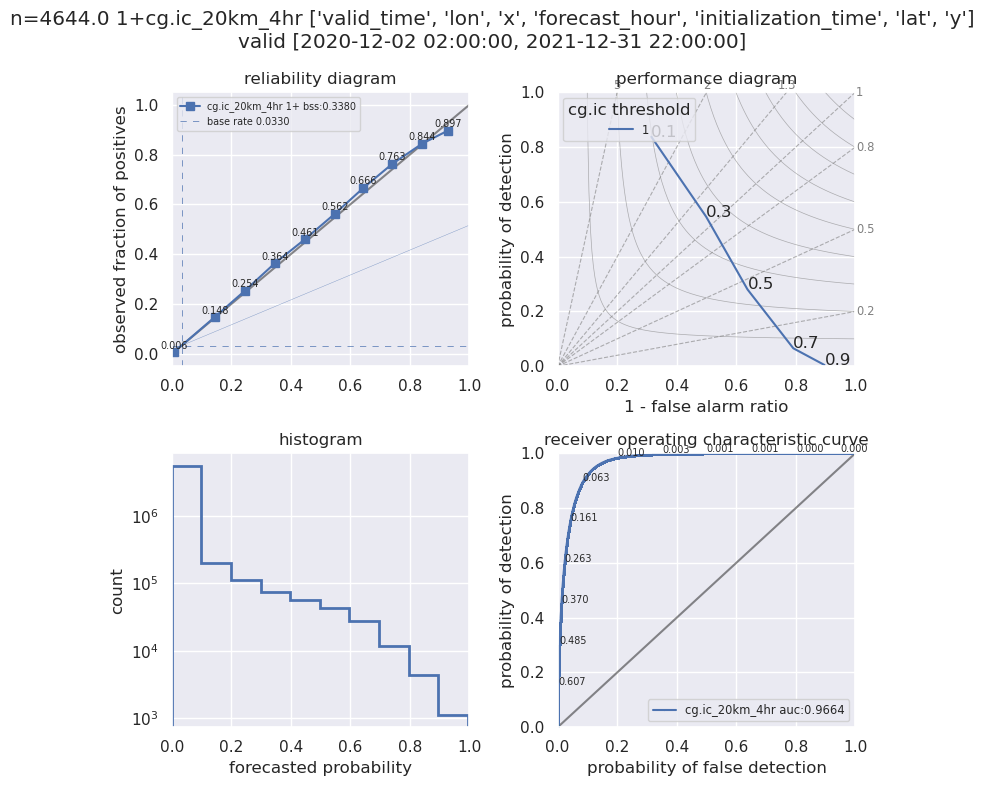

In [21]:
# Used to group overlapping valid_times from different init_times
# like fhr=1 from today's 00 UTC init and fhr=25 from previous day.
# But not now. We want to filter by forecast_hour.
levels = list(set(Y.index.names) - {"fold", "fit"})
Y = Y.groupby(level=levels).mean()
ensmean = Y.xs("y_pred", axis="columns", level=0)
obs = Y.xs("y_label", axis="columns", level=0)

assert "fit" not in ensmean.index.names, (
    "fit should not be a MultiIndex level of ensmean, "
    "the average probability over nfits."
)

obs = obs[f]
fcst = ensmean[f]
pthresh = pd.Series(np.round(np.arange(0.1, 1.1, 0.2), 2), name=f"fcst\np thresh")

valid_range_str = (
    f'[{ensmean.index.get_level_values("valid_time").min()},'
    f' {ensmean.index.get_level_values("valid_time").max()}]'
)

_ = stat_plots(
    obs,
    fcst,
    thresh=thresh,
    pthresh=pthresh,
    o_thresh=o_thresh,
    sep=0.15,
    suptitle=f"n={len(ensmean)/1308} {o_thresh}+{f} {levels}\nvalid {valid_range_str}",
)
ofile = f"dnn.{o_thresh:02d}+{obsvar}.all.{'.'.join(levels)}.png"
ofile = tmpdir / os.path.realpath(ofile)
plt.savefig(ofile)
logging.warning(f"made {ofile}")

In [22]:
def pprod(record, fcst=fcst):
    """
    Return DNN probability for the same valid range as
    an spc forecast record.
    Valid range may span consecutive time windows, each
    with an independent DNN probability.
    """
    s = record.name
    issue, valid_start, valid_end = get_issuance_time(s)
    dnntimes = pd.date_range(
        start=valid_start + pd.Timedelta(hours=twin / 2),
        end=valid_end - pd.Timedelta(hours=twin / 2),
        freq=f"{twin}H",
    )

    try:
        thisfcst = fcst.loc[dnntimes]
        # Probability of no occurences during multiple time windows
        # equals product of 1-p for each time window.
        prob_none = (1 - thisfcst).groupby(["y", "x"]).prod()
        # Probability of one or more occurrences is 1 minus that.
        p = 1 - prob_none
        return p
    except KeyError as err:
        logging.info(f"{err} {s} {issue} [{valid_start},{valid_end}]")
    except:
        logging.error(f"pprod broke on {s} {issue} [{valid_start},{valid_end}]")
        sys.exit(1)


fhr_start = 12 + twin / 2
fhr_end = 36 - twin / 2
logging.warning(
    f"Limit forecast hour range [{fhr_start}, {fhr_end}], get ensemble mean"
)
ensmean = (
    Y.xs(slice(fhr_start, fhr_end), level="forecast_hour")
    .groupby(level=["valid_time", "y", "x"])
    .mean()
)

pprod_par = tmpdir / f"ps.fhr{fhr_start}-{fhr_end}.{o_thresh:02d}+{platform}.par"
if not clobber and os.path.exists(pprod_par):
    logging.warning(f"use old dnn probability product output {pprod_par}")
    p = pd.read_parquet(pprod_par)
else:
    time0 = time.time()
    logging.warning(
        f"Save dnn probability for each spc forecast (i.e. record) to {pprod_par}"
    )
    tqdm.pandas()
    p = spc_fcst.groupby("record").progress_apply(pprod, fcst=ensmean)
    p.to_parquet(pprod_par)
    print(time.time() - time0)

logging.warning(
    "get (issuance time, valid hours) from DNN forecasts matched to SPC records"
)
x = [get_issuance_time(s) for s in tqdm(p.index.get_level_values("record"))]
issue, valid_start, valid_end = map(np.array, zip(*x))

valid_start_hours = np.array([x.hour for x in valid_start])
valid_end_hours = np.array([x.hour for x in valid_end])

2023-11-27 15:13:51,468 Limit forecast hour range [14.0, 34.0], get ensemble mean
2023-11-27 15:13:53,494 use old dnn probability product output /glade/derecho/scratch/ahijevyc/tmp/ps.fhr14.0-34.0.01+wbug.par
2023-11-27 15:13:55,187 get (issuance time, valid hours) from DNN forecasts matched to SPC records
100%|██████████| 6092664/6092664 [01:43<00:00, 58794.42it/s]


## get obs at DNN times
### verify, plot, overlay on SPC scores

n=380 1+cg.ic_20km_4hr [('1300', 0, 4)] 0.3098
n=389 1+cg.ic_20km_4hr [('1700', 0, 4)] 0.3091
n=398 1+cg.ic_20km_4hr [('2100', 0, 4)] 0.3110
n=375 1+cg.ic_20km_4hr [('1700', 4, 12)] 0.3305
n=400 1+cg.ic_20km_4hr [('2100', 4, 12)] 0.3329
n=383 1+cg.ic_20km_4hr [('0130', 4, 12)] 0.3328
n=386 1+cg.ic_20km_4hr [('0600', 12, 16)] 0.2988
n=360 1+cg.ic_20km_4hr [('0600', 16, 20)] 0.3269
n=415 1+cg.ic_20km_4hr [('1300', 16, 20)] 0.3277
n=366 1+cg.ic_20km_4hr [('0600', 20, 0)] 0.3949
n=406 1+cg.ic_20km_4hr [('1300', 20, 0)] 0.3989
n=400 1+cg.ic_20km_4hr [('1700', 20, 0)] 0.3917


2023-11-27 16:39:54,047 made /glade/work/ahijevyc/NSC_objects/notebooks/dnn.01+cg.ic_20km_4hr.png


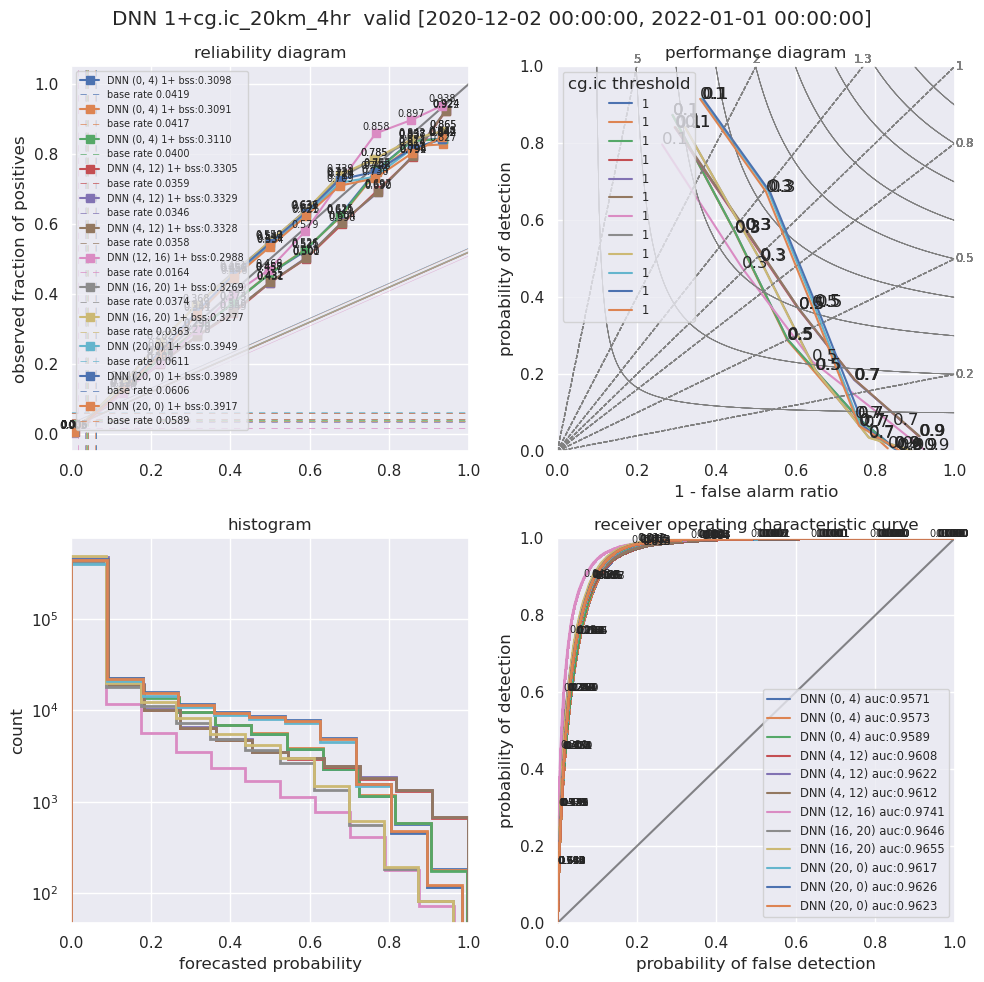

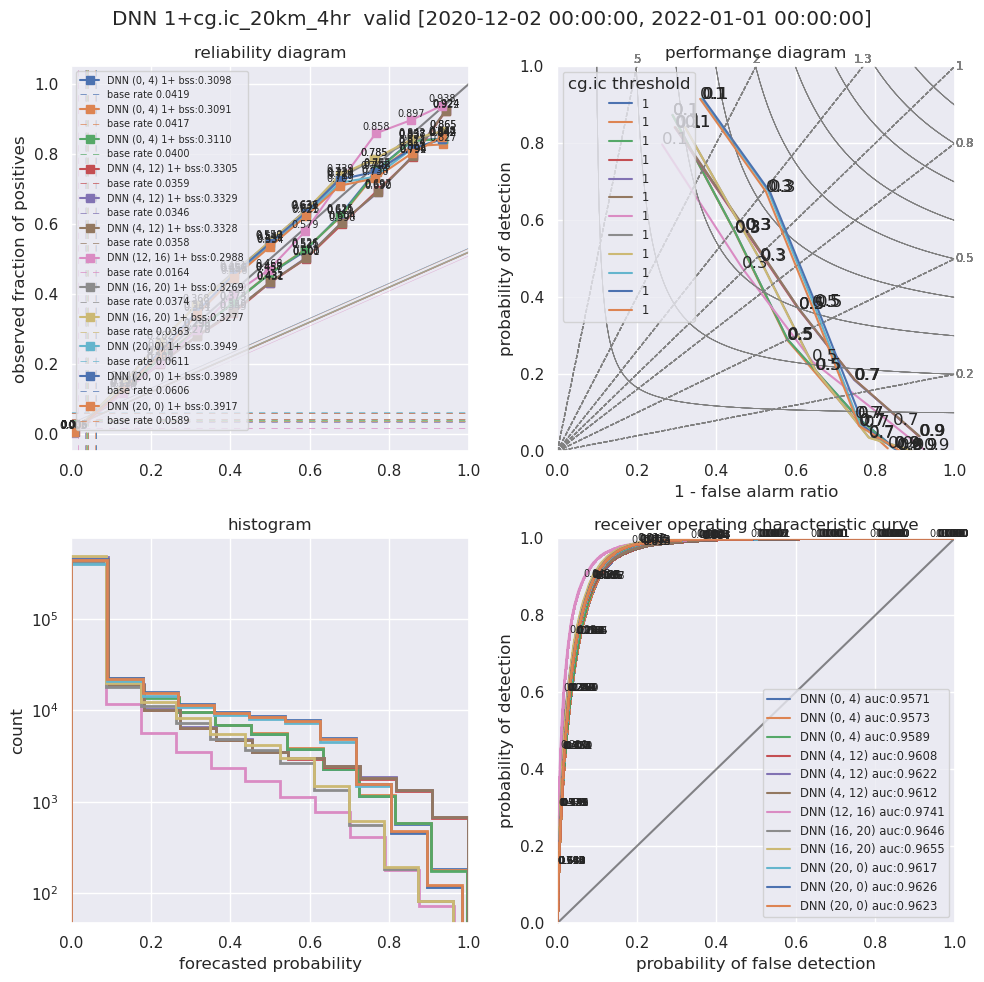

In [28]:
obs = spc_fcst.reorder_levels(p.index.names).loc[p.index, f]
fcst = p[f]
# fcst = fcst.map(ztfs)  # round down DNN probs to limited SPC prob levels

keep_SPC_fig = False
if not keep_SPC_fig:
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 5, nrows * 5))

for prodids in prodidss:
    iprodid = (
        pd.Series(list(zip(issue, valid_start_hours, valid_end_hours)))
        .isin(prodids)
        .values
    )
    print(f"n={iprodid.sum()/1308:.0f} {o_thresh}+{f} {prodids}", end=" ")

    ihr = spc_fcst.prodid.isin(prodids)
    assert ihr.sum()
    # DNN forecasts are missing when obsvar is missing in twin-h time window.
    # However there may be valid obsvar within longer valid time window of SPC forecast.
    # get_obs allows for missing obsvar. It just takes the mean of what is
    # available and then multiplies it by the total time window length.
    # e.g. you get a valid lightning count from get_obs(pd.to_datetime("20210827T20"), pd.to_datetime("20210828T00"), obsvar, 2, rptdist)
    # but labels is missing for one of the 2-h components of that 4-hour SPC forecast valid time window.
    # labels.loc[("2021-08-27", "2021-08-27 21:00:00", 12, 48, slice(None))]
    missing_DNN_forecasts = set(spc_fcst[ihr].groupby("record").first().index) - set(
        p[iprodid].groupby("record").first().index
    )
    if len(missing_DNN_forecasts):
        logging.warning(f"{len(missing_DNN_forecasts)} missing DNN forecasts")
        print(missing_DNN_forecasts)

    missing_SPC_forecasts = set(p[iprodid].groupby("record").first().index) - set(
        spc_fcst[ihr].groupby("record").first().index
    )
    if len(missing_SPC_forecasts):
        logging.warning(f"{len(missing_SPC_forecasts)} missing SPC forecasts")
        print(missing_SPC_forecasts)

    thisf = fcst[iprodid]
    thisf.name = "DNN" + valid_hour_str(prodids)

    fig = stat_plots(
        obs[iprodid],
        thisf,
        thresh=thresh,
        pthresh=pthresh,
        o_thresh=o_thresh,
        sep=0.15,
        n_bins=11,
        fig=fig,
    )
title = f"DNN {o_thresh}+{f}  valid [{valid_start.min()}, {valid_end.max()}]"
plt.suptitle(title, wrap=True)
plt.tight_layout()

ofile = tmpdir / f"dnn.{o_thresh:02d}+{f}.png"
fig.savefig(ofile)
logging.warning(f"made {ofile}")
fig

In [24]:
products = ["SPC", "DNN"]
issuances = ["0600", "1300", "1700", "2100", "0130"]
valid_hr_str = "valid range hours UTC"
assert twin == 4
if obsvar == "cg.ic":
    bss = {
        # obsvar = "cg.ic" o_thresh = 1 twin = 4 rptdist = 20
        "[12,16)": [
            (0.1095, 0.2988),
            (np.nan, np.nan),
            (np.nan, np.nan),
            (np.nan, np.nan),
            (np.nan, np.nan),
        ],
        "[16,20)": [
            (0.1349, 0.3269),
            (0.1700, 0.3277),
            (np.nan, np.nan),
            (np.nan, np.nan),
            (np.nan, np.nan),
        ],
        "[20, 0)": [
            (0.2794, 0.3949),
            (0.2916, 0.3989),
            (0.3110, 0.3917),
            (np.nan, np.nan),
            (np.nan, np.nan),
        ],
        "[ 0, 4)": [
            (np.nan, np.nan),
            (0.1947, 0.3098),
            (0.2254, 0.3091),
            (0.2463, 0.3110),
            (np.nan, np.nan),
        ],
        "[ 4,12)": [
            (np.nan, np.nan),
            (np.nan, np.nan),
            (0.1657, 0.3305),
            (0.1955, 0.3329),
            (0.2576, 0.3328),
        ],
    }
if obsvar == "flashes":
    bss = {
        # obsvar = "flashes" o_thresh = 1 twin = 4 rptdist = 20
        "[12,16)": [
            (0.1102, 0.2959),
            (np.nan, np.nan),
            (np.nan, np.nan),
            (np.nan, np.nan),
            (np.nan, np.nan),
        ],
        "[16,20)": [
            (0.1329, 0.3215),
            (0.1681, 0.3216),
            (np.nan, np.nan),
            (np.nan, np.nan),
            (np.nan, np.nan),
        ],
        "[20, 0)": [
            (0.2796, 0.3972),
            (0.2910, 0.3963),
            (0.3131, 0.3977),
            (np.nan, np.nan),
            (np.nan, np.nan),
        ],
        "[ 0, 4)": [
            (np.nan, np.nan),
            (0.1948, 0.3104),
            (0.2255, 0.3097),
            (0.2458, 0.3118),
            (np.nan, np.nan),
        ],
        "[ 4,12)": [
            (np.nan, np.nan),
            (np.nan, np.nan),
            (0.1644, 0.3313),
            (0.1914, 0.3325),
            (0.2504, 0.3331),
        ],
    }

d = pd.DataFrame(bss, index=issuances)
d.index.name = "issuances UTC"
d.columns.name = valid_hr_str
d

valid range hours UTC,"[12,16)","[16,20)","[20, 0)","[ 0, 4)","[ 4,12)"
issuances UTC,,,,,
0600,"(0.1095, 0.2988)","(0.1349, 0.3269)","(0.2794, 0.3949)","(nan, nan)","(nan, nan)"
1300,"(nan, nan)","(0.17, 0.3277)","(0.2916, 0.3989)","(0.1947, 0.3098)","(nan, nan)"
1700,"(nan, nan)","(nan, nan)","(0.311, 0.3917)","(0.2254, 0.3091)","(0.1657, 0.3305)"
2100,"(nan, nan)","(nan, nan)","(nan, nan)","(0.2463, 0.311)","(0.1955, 0.3329)"
0130,"(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(0.2576, 0.3328)"


In [25]:
spc = d.applymap(lambda x: x[0])
dnn = d.applymap(lambda x: x[1])
if obsvar == "cg.ic" and fcst.isin([0, 0.1, 0.4, 0.7]).all():
    dnn.loc["1300", "[ 0, 4)"] = 0.2581
    dnn.loc["1700", "[ 0, 4)"] = 0.2568
    dnn.loc["2100", "[ 0, 4)"] = 0.2596
    dnn.loc["1700", "[ 4,12)"] = 0.2939
    dnn.loc["2100", "[ 4,12)"] = 0.2951
    dnn.loc["0130", "[ 4,12)"] = 0.2952
    dnn.loc["0600", "[12,16)"] = 0.2451
    dnn.loc["0600", "[16,20)"] = 0.2366
    dnn.loc["1300", "[16,20)"] = 0.2374
    dnn.loc["0600", "[20, 0)"] = 0.3105
    dnn.loc["1300", "[20, 0)"] = 0.3116
    dnn.loc["1700", "[20, 0)"] = 0.3098

In [26]:
dnn

valid range hours UTC,"[12,16)","[16,20)","[20, 0)","[ 0, 4)","[ 4,12)"
issuances UTC,,,,,
0600,0.2988,0.3269,0.3949,NaN,NaN
1300,NaN,0.3277,0.3989,0.3098,NaN
1700,NaN,NaN,0.3917,0.3091,0.3305
2100,NaN,NaN,NaN,0.3110,0.3329
0130,NaN,NaN,NaN,NaN,0.3328


/glade/u/home/ahijevyc/miniconda3/envs/tf2/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/glade/u/home/ahijevyc/miniconda3/envs/tf2/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/glade/u/home/ahijevyc/miniconda3/envs/tf2/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/glade/u/home/ahijevyc/miniconda3/envs/tf2/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/glade/u/home/ahijevyc/miniconda3/envs/tf2/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/glade/u/home/ahijevyc/miniconda3/envs/tf2/lib/python3.10/site-packages/seaborn/algorithms.py:98: Ru

/glade/derecho/scratch/ahijevyc/tmp/barplot.png


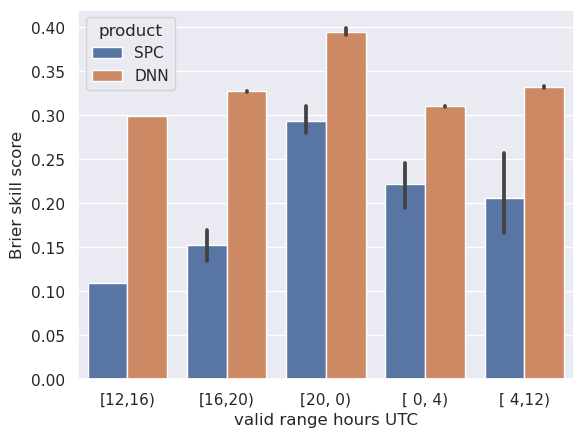

In [27]:
d = pd.concat([spc, dnn], axis=0, keys=products, names=["product", "issuance"])
d = d.reset_index().melt(
    id_vars=["product", "issuance"],
    var_name=valid_hr_str,
    value_name="Brier skill score",
)

g = sns.barplot(d, x=valid_hr_str, y="Brier skill score", hue="product")
g.set_ylim(0.0, 0.42)
ofile = tmpdir / "barplot.png"
plt.savefig(ofile)
print(ofile)

2023-11-09 12:37:30,270 /glade/derecho/scratch/ahijevyc/tmp/cg.ic.relplot.png


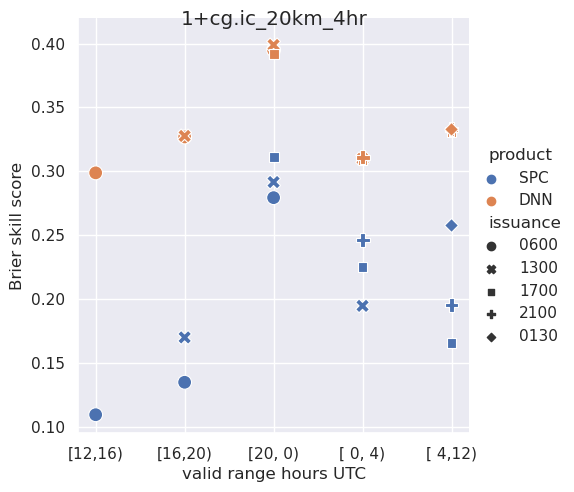

In [29]:
g = sns.relplot(
    d,
    x=valid_hr_str,
    y="Brier skill score",
    hue="product",
    style="issuance",
    kind="scatter",
    s=100,
)
plt.suptitle(f"{o_thresh}+{f}")
g.set(ylim=(0.095, 0.42))
ofile = tmpdir / f"{obsvar}.relplot.png"
g.savefig(ofile)
logging.warning(ofile)

2023-11-09 12:37:30,664 /glade/derecho/scratch/ahijevyc/tmp/cg.ic_20km_4hr.heatmap.png


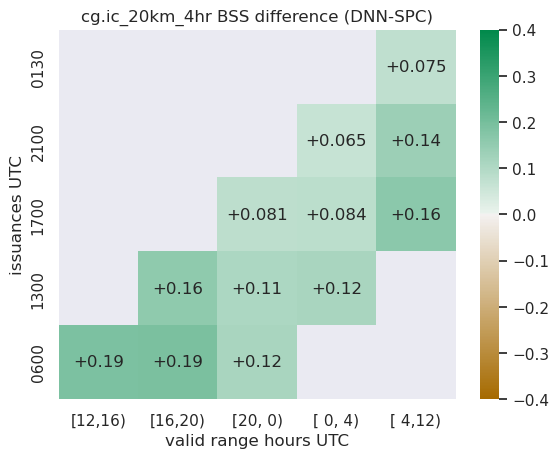

In [30]:
g = sns.heatmap(
    dnn - spc,
    annot=True,
    vmin=-0.4,
    vmax=0.4,
    cmap=sns.diverging_palette(45, 140, s=100, as_cmap=True),
    fmt="+.2",
)
g.set_title(f"{f} BSS difference (DNN-SPC)")
g.invert_yaxis()
ofile = tmpdir / f"{f}.heatmap.png"
plt.savefig(ofile)
logging.warning(ofile)

(1, 2924.0063484741277)

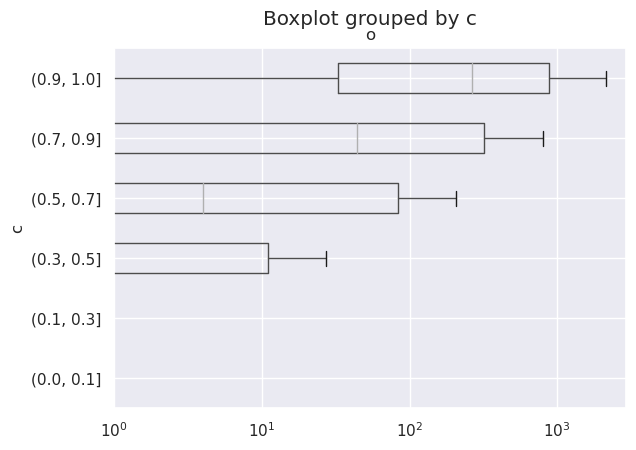

In [31]:
sample = pd.DataFrame(dict(f=fcst, o=obs))
sample["c"] = pd.cut(sample.f, [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1])
ax = sample.boxplot(column="o", by="c", vert=False, showfliers=False)
ax.set_xscale("log")
ax.set_xlim(left=1)